### To Do (11/15):
0. Check physics engine parameters for more effective settings for locomotion
1. Data gathering changes:
    * Run for 2-3 seconds, to alleviate transient response
    * Then run each parameter settings for 5 cycles
    * Start state should be after 2-3 of these cycles completed
    * End state should be after 5 cycles completed
    * **Run for many more datapoints** - aim for 10k initially
2. Data analysis changes:
    * Divide displacement measures by time (end-start)
    * Split datapoints into "bins" (+/- 10 degrees) and maximize displacement in each bin 
    * Ensure within each bin, we have a sufficient amount of samples
    * Change measure to maximal displacement along chosen vector (dot product)
3. Run gaits with different initial conditions and measure robustness

# Data Processing
### (skip to below for charts and discussion)

In [1]:
import os
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from IPython.display import display
from mp_learning import snake_data
import matplotlib
import numpy as np
import mpld3
from mpld3 import fig_to_html, plugins

# mpld3.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# HELPER FUNCTIONS
# 1 - Calculate slope of points, input: 1x91 snake state array
def slope ( points, m="no_debug" ):
    X, Y = [], []
    x_mid = points[39]
    y_mid = points[40]
    for i in [0,6]:
        X.append(points[i*13] )
        Y.append(points[(i*13)+1] )
    s_x = np.std(X)
    s_y = np.std(Y)
    corr_x_y = np.corrcoef(X,Y)
    slope = corr_x_y[0,1]*(s_y / s_x)
    quadrant = 0
    point = []
    if (X[0] > X[-1]) and (slope >= 0.0):
        quadrant = 1
        point = [1, slope]
    elif (X[0] < X[-1]) and (slope < 0.0):
        quadrant = 2
        point = [-1, -slope]
    elif (X[0] < X[-1]) and (slope >= 0.0):
        quadrant = 3
        point = [-1, -slope]
    elif (X[0] > X[-1]) and (slope < 0.0):
        quadrant = 4
        point = [1, slope]
    else:
        raise ValueError("Invalid slope/quadrant computation")
    if (m == "debug"):
        print "X: ",X
        print "Y: ",Y
        print "quad: ", quadrant
        print "slope: ", slope
        print "point: ", point
        point1 = [10, 10*slope]
        point2 = [-10, -10*slope]
        plot_snake_state_pts(X,Y, point1, point2)
    return point, quadrant

def scatter3d(x, title1, y, title2, z, title3, cs, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure(figsize=(10,6))
    ax = Axes3D(fig)
    ax.scatter(x, y, z)
    scalarMap.set_array(cs)
    fig.colorbar(scalarMap)
    ax.set_xlabel(title1)
    ax.set_ylabel(title2)
    ax.set_zlabel(title3)
    plt.show()
    
def plot_snake_state ( state ):
    pts = []
    for i in range(0,7):
        pts.append(state[i*13:i*13+2])
    pts = np.asarray(pts)
    fig = plt.figure()
    plt.scatter(pts[:,0], pts[:,1])
    plt.ylim([-40,40])
    plt.xlim([-40,40])
    plt.show()
    
def get_snake_xy ( state ):
    pts = []
    for i in range(0,7):
        pts.append(state[i*13:i*13+2])
    pts = np.asarray(pts)
    return pts
    
def plot_snake_state_pts ( points_x, points_y, pt1, pt2):
#     pts = np.asarray(np.concatenate((points_x,points_y),axis=1)
    fig = plt.figure()
    ax = fig.gca()
    plt.scatter(np.asarray(points_x), np.asarray(points_y))
    plt.ylim([-25,25])
    plt.xlim([-25,25])
    ax.set_xticks(np.arange(-25,25,5))
    ax.set_yticks(np.arange(-25,25,5))
    
    ax.plot([pt1[0], pt2[0]],[pt1[1], pt2[1]], "r--")
    
    plt.grid()
    plt.show()

FILEHOME = os.environ["PRACSYS_PATH"]
datapath = FILEHOME + '/prx_output/cpg_data_5000_dim9.txt'
print datapath

model = snake_data.Model(datapath, 'snake')
# gp = snake_data.SGPRegression(model)


/home/colin/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


warning in stationary: failed to import cython module: falling back to numpy
/home/colin/Repos/prx_ws/src//prx_output/cpg_data_5000_dim9.txt
Before Trimming:  (9990, 9)


In [2]:
print model.box_w.shape
print model.states.shape
for i in range(0, model.box_l.shape[0]):
    print model.box_l[i], model.box_w[i]

(374,)
(374, 21, 91)
25.2968483565 7.40158851937
21.922616913 17.8288036139
12.0513590763 9.45012025036
22.8481611865 8.48690787916
14.0252219934 9.41770762913
24.0936689488 7.09003093325
27.6428459787 10.069512649
25.2719429136 13.3906162796
27.7002610735 5.15200751409
22.4959579527 13.3918502168
19.4374385749 10.8713205911
14.54430164 7.80330630141
22.0557025022 7.29117104781
25.4744993842 8.91971697078
23.7269317694 21.3508129398
22.2350341295 18.1290562894
22.7680088732 7.24737778849
16.3738150018 14.6074690595
27.9999172421 4.0155303972
26.37901819 8.77962506871
27.2944728134 5.73637309709
19.5224313477 17.2969348658
12.2387308606 10.1339870318
11.5572029175 8.33586977828
27.5966612921 5.38167169694
22.1510225097 5.5478394398
21.6436038577 8.76156885531
19.9385690692 7.05709257268
23.1725327851 16.9779275553
23.9171796095 9.33815289371
25.8097250541 7.76984518114
19.4054546867 11.9213357487
19.9066095024 7.63349001652
25.0016898989 8.75806798448
18.9054469765 8.71680663407
16.2625

# Analysis
Note: All below analysis has been performed over random sampling of four parameter values 

$$\textrm{freq, phase_offset, Ampl_left, Ampl_right} <=> (\nu,\delta\phi, \alpha_l, \alpha_r)$$

Where our goal is to find parameter settings which maximize displacement in "useful" directions, e.g. -45$^\circ$, 0$^\circ$, 45$^\circ$.

Above calculations give us:
* **heading change**: calculated as rotation (around z-axis) of linear interpolation of snake's configuration from start to end of applying the parameterized control sequence for 10s
* **displacement angle**: again calculated around z-axis, this is the angle between origin & snake's middle link from $t_{start} = 0s$ and $t_{end} = 10s$
* **total displacement**: this is the L2 distance between the middle link from start to end

### 1 - Plotting distribution of heading changes
Here, we just expect/want to see that we have a good variety of heading changes for the snake's configuration so that we can choose from a variety of "gaits" to use in SST/iSST

In [3]:
# Histogram with modified axes/grid
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111)
ax.grid(color='lightgrey', linestyle='solid')

bins = np.linspace(-180,180,36)
_ = ax.hist(model.heading_change_norm, bins, histtype='stepfilled', fc='lightblue', alpha=0.5)
ax.set_ylabel("Count", fontsize=12)
ax.set_xlabel("Heading Change (degrees/second)", fontsize=12)
ax.set_xlim(-90,90)
ax.set_ylim(0,500)
mpld3.display(fig)

### 2 - Checking for good "coverage" over parameter space
Interactive plot of all four variables in pairs, showing sample coverage of parameter space where that space is
* **frequency**: (0.1, 1.0)
* **phase offset**: (0.2, 1.0)
* **ampl left**: (0.25, 0.75)
* **ampl right**: (0.25, 0.75)

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(8,8), sharex='col', sharey='row')
fig.subplots_adjust(hspace=0.3)

# cm = plt.get_cmap('jet')
# cNorm = matplotlib.colors.Normalize(vmin=min(model.disp[:]), vmax=max(model.disp[:]))
# scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
# scalarMap.set_array(model.disp[:])

# ax[0] = fig.add_subplot(211, axisbg='#EEEEEE')
axs.flat[0].grid(color='lightgray', alpha=0.7, linestyle='solid')
axs.flat[0].scatter(model.controls[:,0],model.controls[:,1], s=20, alpha=0.5)
axs.flat[0].set_xlabel("frequency", fontsize=12)
axs.flat[0].set_ylabel("phase offset", fontsize=12)

# ax[0] = fig.add_subplot(211, axisbg='#EEEEEE')
axs.flat[1].grid(color='lightgray', alpha=0.7, linestyle='solid')
axs.flat[1].scatter(model.controls[:,2],model.controls[:,1], s=20, alpha=0.5)
axs.flat[1].set_xlabel("ampl. left", fontsize=12)
axs.flat[1].set_ylabel("phase offset", fontsize=12)

# ax[0] = fig.add_subplot(211, axisbg='#EEEEEE')
axs.flat[2].grid(color='lightgray', alpha=0.7, linestyle='solid')
axs.flat[2].scatter(model.controls[:,0],model.controls[:,3], s=20, alpha=0.5)
axs.flat[2].set_xlabel("frequency", fontsize=12)
axs.flat[2].set_ylabel("ampl. right", fontsize=12)

# ax = fig.add_subplot(212, axisbg='#EEEEEE')
axs.flat[3].grid(color='lightgray', alpha=0.7, linestyle='solid')
points =axs.flat[3].scatter(model.controls[:,2],model.controls[:,3], s=20, alpha=0.5)
axs.flat[3].set_xlabel("ampl. left", fontsize=12)
axs.flat[3].set_ylabel("ampl. right", fontsize=12)

plugins.connect(fig, plugins.LinkedBrush(points))
mpld3.display(fig)

### 3 - Plotting all three measures together
In order to select which parameter values we'd like, we look first at 
1. **heading change v. displacement angle**: Where we would actually expect these to correlate, i.e, if snake rotates to the left, displacement should be in that direction as well
2. **heading change v. total displacement**: Given that the above measures of a certain parameterization are reasonably well correlated, we want to select those which maximize our total displacement of the center link so as to locomote as fast as possible

*Note: below is an interactive chart. Use interaction tools in the toolbar by hovering mouse over bottom left corner or by hovering over individual points in order to see their control parameterizations*

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(8,8), sharex='col')
fig.subplots_adjust(hspace=0.3)

# cm = plt.get_cmap('jet')
# cNorm = matplotlib.colors.Normalize(vmin=min(model.disp[:]), vmax=max(model.disp[:]))
# scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
# scalarMap.set_array(model.disp[:])

# ax[0] = fig.add_subplot(211, axisbg='#EEEEEE')
axs.flat[0].grid(color='lightgray', alpha=0.7, linestyle='solid')
axs.flat[0].scatter(model.heading_change_norm[:],model.disp_angles[:], s=40, alpha=0.5, c=model.disp[:])
axs.flat[0].set_xlabel("heading change ", fontsize=12)
axs.flat[0].set_ylabel("displ. dir ", fontsize=12)
axs.flat[0].set_ylim(-45,45)

# ax = fig.add_subplot(212, axisbg='#EEEEEE')
axs.flat[1].grid(color='lightgray', alpha=0.7, linestyle='solid')
points =axs.flat[1].scatter(model.heading_change_norm[:],model.disp_along_heading[:], s=40, alpha=0.5, c=model.disp[:])
axs.flat[1].set_xlabel("heading change ", fontsize=12)
axs.flat[1].set_ylabel("total displacement ", fontsize=12)
labels = ["Control[{0}]: {1}".format(i,e) for i,e in enumerate(model.controls[:])]
tooltip = plugins.PointLabelTooltip(points, labels)

plugins.connect(fig, plugins.LinkedBrush(points))
plugins.connect(fig, tooltip)
mpld3.display(fig)

In [61]:
print model.controls[306,:]

IndexError: index 306 is out of bounds for axis 0 with size 196

### 4 - Finding gaits which maximize displacement along chosen directions
We can easily find those parameterization which maximize our displacement along some desired set of "learned gait" locomotion directions by constraining the search such that both our displacement and heading directions (already positively correlated) both lie within some threshold of the desired direction. 

Below uses thresh=+/-5$^\circ$, and searches for 9 learned gait locomotion directions which meet that criteria and maximize displacement of the middle link.

#### Plot shows resulting configuration of snake in global frame after applying each learned gait for 10s

In [85]:
print model.heading_change.shape
print int(np.ceil(((model.heading_change.shape[0]+198)/9990.0)*50))
print model.states.shape

(374,)
3
(374, 21, 91)


In [3]:
def rotate_snake(idx,X,Y,degrees):
    s = np.sin(degrees)
    c = np.cos(degrees)

    start_st = get_snake_xy(model.states[idx,19,:])
    cx = start_st[3,0]
    cy = start_st[3,1]
    
    # rotate point
    for i,x in enumerate(X):
        X[i] = (x-cx)*c - (Y[i]-cy)*s
        Y[i] = (x-cx)*s + (Y[i]-cy)*c
        X[i] = X[i] + cx
        Y[i] = Y[i] + cy
    return X,Y

# Search for those points which maximize displacement in chosen directions
desired_directions = [-32.4, -25.2, -18.0, -10.8, -3.6, 3.6, 10.8, 18.0, 25.2, 32.4]
allow_thresh = 3.6

sums = []
for itr in range(1, 201):
    max_d = [0] * len(desired_directions)
    best_indices, best_controls = [0] * len(desired_directions), [0] * len(desired_directions)
    for idx in range(0,len(desired_directions)):
        for i, pt in enumerate(model.controls[:(2*itr)]):
            if (
    #             (model.disp_angles[i] > desired_directions[idx] - allow_thresh) and 
    #             (model.disp_angles[i] < desired_directions[idx] + allow_thresh) and 
                (model.heading_change_norm[i] > desired_directions[idx] - allow_thresh) and 
                (model.heading_change_norm[i] < desired_directions[idx] + allow_thresh)):
                    if (model.disp_along_heading[i] > max_d[idx]):
                        max_d[idx] = model.disp_along_heading[i]
                        best_indices[idx] = i
                        best_controls[idx] = pt
    if itr == 200:
        for j, pt in enumerate(best_controls):
            print pt
            print model.heading_change_norm[best_indices[j]][0], ", ", \
                    model.disp_along_heading[best_indices[j]][0], ", ",\
                    model.box_l[best_indices[j]], ", ",\
                    model.box_w[best_indices[j]], ", "
            
    sum = 0
    for item in max_d:
        try:
            sum += item[0]
        except:
            pass
    sums.append(sum)
print sums
        
# print max_d

fig, ax = plt.subplots(1,1, figsize=(8,6))

for e, pt in enumerate(best_indices):
    conf = get_snake_xy(model.states[pt,20,:])
    st_slp, st_quad = slope(model.states[pt,19,:])
#     if e == 1:
    conf[:,0], conf[:,1] = rotate_snake(pt, conf[:,0], conf[:,1], -np.arctan(st_slp[1] / st_slp[0]))
    if st_quad in [2,3]:
        conf[:,0], conf[:,1] = rotate_snake(pt, conf[:,0], conf[:,1], np.pi)
    start_state = get_snake_xy(model.states[pt,19,:])
    for i in range(0,conf.shape[0]):
        conf[i,0] = conf[i,0] - start_state[3,0]
        conf[i,1] = conf[i,1] - start_state[3,1]
    ax.plot(conf[:,0], conf[:,1], lw=2, alpha=0.4, label="Dir:{0}".format(desired_directions[e]))
    ax.scatter(conf[0,0], conf[0,1], s=25)
    ax.scatter(conf[-1,0], conf[-1,1], s=25)
start_conf = np.asarray([[12,0],[8, 0],[4, 0],[0, 0],[-4, 0],[-8, 0],[-12, 0]])
ax.scatter(start_conf[0,0], start_conf[0,1], s=25)
ax.scatter(start_conf[-1,0], start_conf[-1,1], s=25)
ax.plot(start_conf[:,0], start_conf[:,1], lw=5,alpha=0.5, label="Start")
ax.grid(color='lightgray', alpha=0.7)
ax.legend()
mpld3.display(fig)

[ 0.72008336  0.77831417  0.45577309  0.78341508  0.71583551  0.87251413
  0.87923014  0.76849961  0.38303125]
-29.0696 ,  3.64494 ,  17.4396146674 ,  16.3336105351 , 
[ 0.61661261  0.83115357  0.4432117   0.27655101  0.85740954  0.6668511
  0.61534017  0.59387165  0.55033398]
-26.5594 ,  3.34796 ,  22.610150219 ,  17.467404038 , 
[ 0.62138116  0.85277855  0.32141274  0.55496097  0.84036034  0.58002073
  0.64165854  0.5329746   0.4419108 ]
-17.1521 ,  3.70596 ,  22.6906305438 ,  15.9418791699 , 
[ 0.28730726  0.76940769  0.75976813  0.21491627  0.72285467  0.7591663
  0.77029306  0.65276378  0.53762436]
-8.2356 ,  3.34676 ,  26.9483685317 ,  15.1075121641 , 
[ 0.38849917  0.35528788  0.23473057  0.30308074  0.23847832  0.98305368
  0.58847106  0.78091162  0.63432086]
-0.671221 ,  4.38611 ,  25.4744993842 ,  8.91971697078 , 
[ 0.61511719  0.96877402  0.33695349  0.30674592  0.4507629   0.94097692
  0.99230075  0.42603582  0.47479057]
4.49046 ,  4.00785 ,  24.2949528175 ,  10.1232231802 

In [ ]:
[2.7712840437889099, 3.3910706043243408, 3.3910706043243408, 3.4954369068145752, 5.600325345993042, 5.600325345993042, 9.9864304065704346, 14.909912824630737, 17.01668906211853, 17.01668906211853, 17.01668906211853, 17.01668906211853, 17.01668906211853, 17.01668906211853, 20.705931663513184, 20.705931663513184, 20.705931663513184, 20.705931663513184, 23.076724767684937, 23.076724767684937, 23.076724767684937, 23.076724767684937, 23.076724767684937, 23.076724767684937, 23.076724767684937, 23.963047027587891, 23.963047027587891, 23.963047027587891, 23.963047027587891, 23.963047027587891, 25.336625099182129, 25.336625099182129, 25.336625099182129, 25.336625099182129, 25.336625099182129, 25.336625099182129, 25.336625099182129, 25.61308479309082, 25.61308479309082, 25.61308479309082, 25.61308479309082, 25.61308479309082, 25.61308479309082, 25.61308479309082, 25.61308479309082, 25.61308479309082, 25.61308479309082, 25.61308479309082, 25.61308479309082, 25.61308479309082, 25.804880380630493, 25.804880380630493, 25.804880380630493, 25.804880380630493, 25.804880380630493, 25.804880380630493, 26.550873517990112, 30.195813894271851, 30.195813894271851, 30.195813894271851, 30.195813894271851, 30.195813894271851, 30.513905763626099, 30.513905763626099, 30.513905763626099, 30.513905763626099, 32.102735996246338, 32.102735996246338, 32.102735996246338, 32.102735996246338, 32.102735996246338, 32.102735996246338, 32.102735996246338, 32.102735996246338, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873]

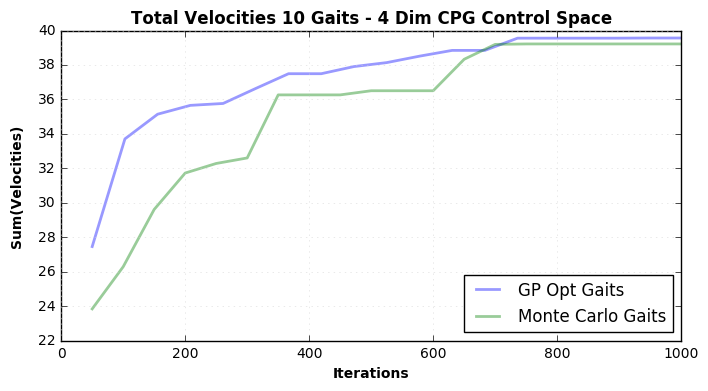

In [14]:
x50 = [ 0.000  ,0.000 , 3.132 , 3.102 , 3.281  ,4.488 , 3.645  ,3.573 , 2.729  ,3.504]
x100 = [ 2.854 , 2.728,  3.199,  3.102,  3.281 , 4.488,  3.645 , 3.573,  3.331  ,3.504]
x150 = [ 3.760 , 2.728,  3.352,  3.102,  3.281 , 4.488,  3.645 , 3.949,  3.331  ,3.504]
x200 = [ 3.760 , 3.147,  3.352,  3.102,  3.281,  4.488,  3.645 , 3.949,  3.425  ,3.504]
x250 = [ 3.760 , 3.147,  3.438,  3.102,  3.281,  4.488,  3.645 , 3.949,  3.449  ,3.504]
x300 = [ 3.760,  3.147,  3.438,  3.102,  4.143,  4.488,  3.645 , 3.949,  3.460  ,3.504]
x350 = [ 3.760,  3.620,  3.438,  3.102,  4.384,  4.488,  3.786 , 3.949,  3.460 , 3.504]
x400 = [ 3.760,  3.620,  3.438,  3.102,  4.384,  4.488,  3.786 , 3.949,  3.460 , 3.504]
x450 = [ 3.760,  3.620,  3.853,  3.102,  4.384,  4.488,  3.786 , 3.949,  3.460 , 3.504]
x500 = [ 3.760,  3.620,  3.853,  3.332,  4.384,  4.488,  3.786 , 3.949,  3.460 , 3.504]
x550 = [ 3.760,  3.620,  3.853,  3.332,  4.384,  4.488,  4.159 , 3.949,  3.460 , 3.504]
x600 = [ 3.760,  3.620,  3.853,  3.668,  4.384,  4.488,  4.159 , 3.949,  3.460 , 3.504]
x650 = [ 3.760,  3.620,  3.853,  3.668,  4.384,  4.488,  4.159 , 3.949,  3.460 , 3.504]
x700 = [ 3.760,  3.620 , 3.853,  3.862,  4.900,  4.488,  4.159 , 3.949,  3.460 , 3.504]
x750 = [ 3.760,  3.620 , 3.853,  3.862,  4.900,  4.488,  4.159 , 3.949,  3.460 , 3.504]
x800 = [ 3.760,  3.620 , 3.853,  3.862,  4.900,  4.488 , 4.159 , 3.949,  3.460 , 3.504]
x850 = [ 3.760,  3.620 , 3.853,  3.862,  4.900 , 4.488 , 4.159 , 3.949,  3.460 , 3.504]
x900 = [ 3.760,  3.620 , 3.853,  3.871,  4.900,  4.488 , 4.159 , 3.949,  3.460 , 3.504]
x950 = [ 3.760,  3.620 , 3.853,  3.871,  4.900,  4.488 , 4.159 , 3.949,  3.460 , 3.504]

x = [np.sum(x50), np.sum(x100), np.sum(x150), np.sum(x200), np.sum(x250), 
    np.sum(x300), np.sum(x350), np.sum(x400), np.sum(x450), np.sum(x500), 
    np.sum(x550), np.sum(x600), np.sum(x650), np.sum(x700), np.sum(x750), 
    np.sum(x800), np.sum(x850), np.sum(x900), np.sum(x950)]
y = [23.835734844207764, 26.283007383346558, 29.610525131225586, 31.723360538482666, 
     32.279383659362793, 32.599455118179321, 36.261245727539062, 36.261245727539062, 
     36.261245727539062, 36.502230644226074, 36.502230644226074, 36.502230644226074, 
     38.330830335617065, 39.194744110107422, 39.219231367111206, 39.219231367111206, 
     39.219231367111206, 39.219231367111206, 39.219231367111206, 39.219231367111206]
d_y = np.linspace(50,1000,20)
d_x = np.linspace(50,1000,19)

# print len(x)

fig, ax = plt.subplots(1,1, figsize=(8,4))

ax.plot(d_x, x, lw=2, alpha=0.4, label="GP Opt Gaits")
ax.plot(d_y, y, lw=2, alpha=0.4, label="Monte Carlo Gaits")
ax.grid(color='lightgray', alpha=0.7)
ax.set_title("Total Velocities 10 Gaits - 4 Dim CPG Control Space", fontweight='bold')
ax.set_xlabel("Iterations", fontweight='bold')
ax.set_ylabel("Sum(Velocities)", labelpad=10, fontweight='bold')

ax.legend(loc="lower right")
fig.show()

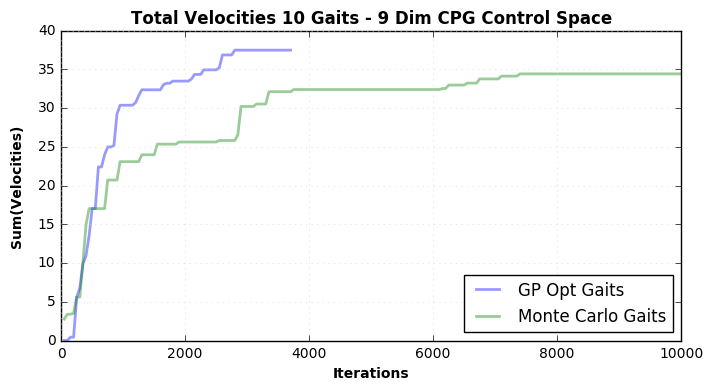

In [15]:
x100 = [ 0.000,  0.000,  0.000,  0.000,  0.975 , 0.113 , 0.000,  0.000,  0.000,  0.000]
x150 = [ 0.000,  0.000,  0.000,  2.214,  0.975 , 0.311 , 0.000,  0.000,  0.000,  0.000]
x200 = [ 1.318,  0.000,  0.000,  2.308,  0.975 , 0.311 , 0.000,  2.933,  0.919,  0.000]
x250 = [ 1.318,  0.000,  0.000,  3.223,  0.975 , 0.311 , 0.000,  3.171,  2.217,  0.000]
x300 = [ 1.318,  0.000,  0.000,  3.223,  0.975 , 0.311 , 0.000,  3.171,  2.217,  0.000]
x350 = [ 1.318,  0.000,  0.000,  3.223,  0.975 , 0.376 , 0.000,  3.171,  2.217,  0.000]
x400 = [ 1.318,  0.000,  0.000,  3.223,  3.319 , 0.615 , 0.000,  3.171,  2.217,  0.000]
x450 = [ 1.318,  0.000,  0.000,  3.223,  3.319 , 0.615 , 0.000,  3.171,  2.217,  0.000]
x500 = [ 1.318,  0.000,  0.000,  3.223,  3.319 , 0.615 , 0.000,  3.171,  2.217,  0.000]
x550 = [ 2.589,  0.000,  0.000,  3.223,  3.319 , 1.286 , 0.000,  3.171,  2.217,  0.000]
x600 = [ 2.589,  0.000,  0.000,  3.300,  3.319,  1.286,  0.000,  3.171,  3.061,  0.000]
x650 = [ 2.589,  3.395,  0.000,  3.300,  3.319,  1.286,  0.000,  3.171,  3.061,  0.000]
x700 = [ 2.589,  3.395,  0.000,  3.300,  3.319 , 1.286,  0.000,  3.171,  3.061,  0.000]
x750 = [ 2.589,  3.395,  0.000,  3.300,  3.319 , 1.286,  0.000,  3.171,  3.061,  0.000]
x800 = [ 2.589,  3.395,  0.000,  3.300,  3.319 , 1.286,  0.000,  3.171,  3.061,  0.000]
x850 = [ 2.589,  3.395,  1.830,  3.300,  3.319,  1.286,  0.000,  3.171,  3.061,  0.000]
x900 = [ 2.589,  3.395,  1.830,  3.300,  3.319,  1.286,  0.000,  3.171,  3.061,  0.000]
x950 = [ 2.705,  3.395,  1.830,  3.300,  3.319,  1.286,  0.000,  3.171,  3.061,  0.000]
x1000 = [ 2.705,  3.395,  1.830,  3.300,  3.319,  1.286,  0.000,  3.171,  3.061,  0.000]
x1050 = [ 2.705,  3.395,  1.830,  3.300,  3.319,  1.286,  0.000,  3.171,  3.061,  0.000]
x1100 = [ 2.705,  3.395,  1.830,  3.300,  3.319,  1.286,  0.000,  3.171,  3.061,  0.000]
x1150 = [ 2.705,  3.395,  1.830,  3.300,  3.319,  1.286,  0.000,  3.171,  3.061,  0.000]
x1200 = [ 2.705,  3.395,  1.830,  3.300,  3.319,  1.286,  0.000,  3.171,  3.061,  0.000]
x1250 = [ 2.705,  3.395,  1.830,  3.300,  3.319,  1.286,  0.000,  3.171,  3.061,  0.000]
x1300 = [ 2.705,  3.395,  1.830,  3.300,  3.319,  1.286,  2.208,  3.171,  3.061,  0.000]
x1350 = [ 2.705,  3.395,  1.830,  3.300,  3.319,  1.286,  2.208,  3.171,  3.061,  0.000]
x1400 = [ 2.705,  3.395,  2.133,  3.300,  3.319,  1.286,  2.208,  3.171,  3.061,  0.000]
x1450 = [ 2.705,  3.395,  2.133,  3.300,  3.319,  1.286,  2.208,  3.171,  3.061,  0.000]
x1500 = [ 2.705,  3.395,  2.133,  3.300,  3.319,  1.286,  2.208,  3.171,  3.061,  3.337]

x_new = []
for i in range(1, 75):
    with open("/home/colin/Repos/prx_ws/src/prx_input/maneuvers/stored_maneuvers/opt1_dim9_50k_long/" + str(i*50) + "/summary.txt", "r") as fin:
        fin.readline()
        sum_str = fin.readline()
        x_new.append(float(sum_str[4:]))
#         print str(i*50), ": ", sum_str[4:]
# print len(x_new)

x = [np.sum(x100), np.sum(x150), np.sum(x200), np.sum(x250), np.sum(x300), 
     np.sum(x350), np.sum(x400), np.sum(x450), np.sum(x500), np.sum(x550),
    np.sum(x600), np.sum(x650), np.sum(x700), np.sum(x750), np.sum(x800),
    np.sum(x850), np.sum(x900), np.sum(x950), np.sum(x1000), np.sum(x1050),
    np.sum(x1100), np.sum(x1150), np.sum(x1200), np.sum(x1250), np.sum(x1300), 
     np.sum(x1350), np.sum(x1400), np.sum(x1450), np.sum(x1500)]
y = [2.7712840437889099, 3.3910706043243408, 3.3910706043243408, 3.4954369068145752, 5.600325345993042, 5.600325345993042, 9.9864304065704346, 14.909912824630737, 17.01668906211853, 17.01668906211853, 17.01668906211853, 17.01668906211853, 17.01668906211853, 17.01668906211853, 20.705931663513184, 20.705931663513184, 20.705931663513184, 20.705931663513184, 23.076724767684937, 23.076724767684937, 23.076724767684937, 23.076724767684937, 23.076724767684937, 23.076724767684937, 23.076724767684937, 23.963047027587891, 23.963047027587891, 23.963047027587891, 23.963047027587891, 23.963047027587891, 25.336625099182129, 25.336625099182129, 25.336625099182129, 25.336625099182129, 25.336625099182129, 25.336625099182129, 25.336625099182129, 25.61308479309082, 25.61308479309082, 25.61308479309082, 25.61308479309082, 25.61308479309082, 25.61308479309082, 25.61308479309082, 25.61308479309082, 25.61308479309082, 25.61308479309082, 25.61308479309082, 25.61308479309082, 25.61308479309082, 25.804880380630493, 25.804880380630493, 25.804880380630493, 25.804880380630493, 25.804880380630493, 25.804880380630493, 26.550873517990112, 30.195813894271851, 30.195813894271851, 30.195813894271851, 30.195813894271851, 30.195813894271851, 30.513905763626099, 30.513905763626099, 30.513905763626099, 30.513905763626099, 32.102735996246338, 32.102735996246338, 32.102735996246338, 32.102735996246338, 32.102735996246338, 32.102735996246338, 32.102735996246338, 32.102735996246338, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.381476879119873, 32.515052556991577, 32.515052556991577, 32.957747936248779, 32.957747936248779, 32.957747936248779, 32.957747936248779, 32.957747936248779, 32.957747936248779, 33.212557077407837, 33.212557077407837, 33.212557077407837, 33.212557077407837, 33.754644870758057, 33.754644870758057, 33.754644870758057, 33.754644870758057, 33.754644870758057, 33.754644870758057, 33.754644870758057, 34.114368915557861, 34.114368915557861, 34.114368915557861, 34.114368915557861, 34.114368915557861, 34.114368915557861, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462, 34.401918649673462]
d_y = np.linspace(50,10000,200)
d_x = np.linspace(100,1500,29)


fig, ax = plt.subplots(1,1, figsize=(8,4))
# ax.plot(d_x, x, lw=2, alpha=0.4, label="GP Learned Gaits 2500 Samples")
ax.plot(np.linspace(50,len(x_new)*50,len(x_new)), x_new, lw=2, alpha=0.4, label="GP Opt Gaits")
ax.plot(d_y, y, lw=2, alpha=0.4, label="Monte Carlo Gaits")
ax.grid(color='lightgray', alpha=0.7)
ax.set_title("Total Velocities 10 Gaits - 9 Dim CPG Control Space", fontweight='bold')
ax.set_xlabel("Iterations", fontweight='bold')
ax.set_ylabel("Sum(Velocities)", labelpad=10, fontweight='bold')

ax.legend(loc="lower right")
fig.show()


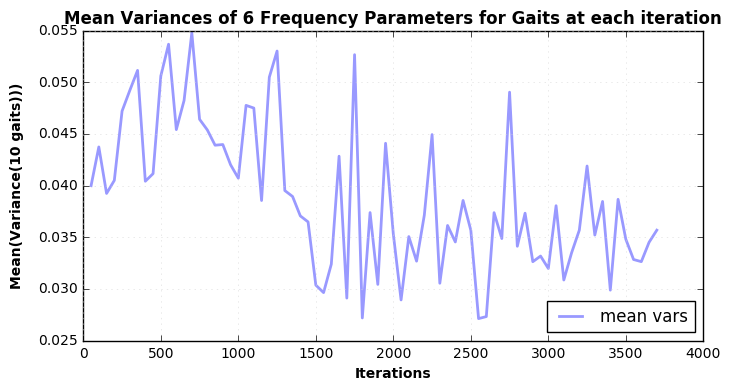

In [46]:
import csv

# varse = []
# for i in range(1, 75):
#     for j in range(0,10):
#         with open("/home/colin/Repos/prx_ws/src/prx_input/maneuvers/stored_maneuvers/opt1_dim9_50k_long/" + str(i*50) + "/maneuver_" + str(j) + ".txt", "r") as fin:
#             x = fin.readline()  
#             varse.append(np.array(x.split(","), dtype=np.float32))
# varse = np.asarray(varse)

mean_vars = []
for i in range(1, 75):
    sums = []
    for j in range(0,10):
        sums.append(np.var(varse[i*j,:6]))
    mean_vars.append(np.mean(sums))
    
fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.plot(np.linspace(50,len(mean_vars)*50,len(mean_vars)), mean_vars, lw=2, alpha=0.4, label="mean vars")
ax.grid(color='lightgray', alpha=0.7)
ax.set_title("Mean Variances of 6 Frequency Parameters for Gaits at each iteration", fontweight='bold')
ax.set_xlabel("Iterations", fontweight='bold')
ax.set_ylabel("Mean(Variance(10 gaits)))", labelpad=10, fontweight='bold')

ax.legend(loc="lower right")
fig.show()


In [37]:
np.var([2,3,3,2,2,3])

0.25

In [6]:
for i in range(0,7):
    ind = i * 13
    print "Link: ", i, "Lin Vel X:", np.max(model.states[:,:,ind+7])
    print "Link: ", i, "Lin Vel Y:", np.max(model.states[:,:,ind+8])
    print "Link: ", i, "Lin Vel Z:", np.max(model.states[:,:,ind+9])
    print "Link: ", i, "Ang Vel X:", np.max(model.states[:,:,ind+10])
    print "Link: ", i, "Ang Vel Y:", np.max(model.states[:,:,ind+11])
    print "Link: ", i, "Ang Vel Z:", np.max(model.states[:,:,ind+12])

Link:  0 Lin Vel X: 8.38176
Link:  0 Lin Vel Y: 7.45885
Link:  0 Lin Vel Z: 0.00292592
Link:  0 Ang Vel X: 0.010304
Link:  0 Ang Vel Y: 0.00162122
Link:  0 Ang Vel Z: 4.58572
Link:  1 Lin Vel X: 8.87816
Link:  1 Lin Vel Y: 9.49229
Link:  1 Lin Vel Z: 0.00124171
Link:  1 Ang Vel X: 0.0102784
Link:  1 Ang Vel Y: 0.00162422
Link:  1 Ang Vel Z: 5.44335
Link:  2 Lin Vel X: 11.4243
Link:  2 Lin Vel Y: 8.34992
Link:  2 Lin Vel Z: 0.00107065
Link:  2 Ang Vel X: 0.010353
Link:  2 Ang Vel Y: 0.00148348
Link:  2 Ang Vel Z: 4.05454
Link:  3 Lin Vel X: 9.82409
Link:  3 Lin Vel Y: 7.63815
Link:  3 Lin Vel Z: 0.00464396
Link:  3 Ang Vel X: 0.0121214
Link:  3 Ang Vel Y: 0.00138643
Link:  3 Ang Vel Z: 5.99777
Link:  4 Lin Vel X: 12.7409
Link:  4 Lin Vel Y: 10.8794
Link:  4 Lin Vel Z: 0.00809013
Link:  4 Ang Vel X: 0.0124375
Link:  4 Ang Vel Y: 0.000786799
Link:  4 Ang Vel Z: 1.80441
Link:  5 Lin Vel X: 10.3297
Link:  5 Lin Vel Y: 10.1006
Link:  5 Lin Vel Z: 0.00866098
Link:  5 Ang Vel X: 0.0145201
Link



# -------- SCRATCH WORK ---------



In [ ]:
rnd_idxs = np.random.randint(0, gp.data_model.train_data.shape[0],10)
gp.train(gp.data_model.train_data[rnd_idxs,:], gp.data_model.train_labels[rnd_idxs,:])

print "Iteration\tAvg. Diff\t\tAvg. Variance"
print "-------------------------------------"
for i in range(0,500):
    # Sample random controls and find control with max variance
    controls_samp = np.concatenate(((np.asarray(random.sample([x / 10000.0 for x in range(10000)],1000)).reshape((1000,1))*0.6)+0.4,
        (np.asarray(random.sample([x / 10000.0 for x in range(10000)],1000)).reshape((1000,1))*0.875)+0.125,
        (np.asarray(random.sample([x / 10000.0 for x in range(10000)],1000)).reshape((1000,1))*0.8)+0.2,
        (np.asarray(random.sample([x / 10000.0 for x in range(10000)],1000)).reshape((1000,1))*0.8)+0.2), axis=1)
    gp_pred, gp_predvar = gp.test(controls_samp)
    max_var = controls_samp[np.argmax(gp_predvar)]
    
    # Find nearest existing control to sampled max variance
    min_dist = 100000.0
    control_idx = -1
    for j,val in enumerate(gp.data_model.train_data):
        if np.sqrt(np.sum(np.square(gp.data_model.train_data[j] - max_var))) < min_dist:
            if j not in rnd_idxs:
                min_dist = np.sqrt(np.sum(np.square(gp.data_model.train_data[j] - max_var)))
                control_idx = j
    # Add new data point to training indices
    rnd_idxs = np.insert(rnd_idxs, len(rnd_idxs), control_idx)
    
    # Train including new data point and output results
#     gp.train(gp.data_model.train_data[rnd_idxs,:], gp.data_model.train_labels[rnd_idxs,:])
    gp.model.set_XY(X=gp.data_model.train_data[rnd_idxs,:], Y=gp.data_model.train_labels[rnd_idxs,:])
    gp.model.optimize('tnc')
    
    gpdata = gp.data_model.test_data[:50, :]
    gplabels = gp.data_model.test_labels[:50, :]
    gppred, gppredvar = gp.test(gpdata)

    gppred_diff = np.abs(gppred - gplabels)
    
    print i, "\t\t", np.mean(gppred_diff), "\t", np.mean(gppredvar)
#     print rnd_idxs

In [15]:
rnd_idxs = np.random.randint(0, gp.data_model.train_data.shape[0],128)
print rnd_idxs

gp.train(gp.data_model.train_data[rnd_idxs,:], gp.data_model.train_labels[rnd_idxs,:])

gpdata = gp.data_model.test_data

gplabels = gp.data_model.test_labels
gppred, gppredvar = gp.test(gpdata)

gppred_diff = np.abs(gppred - gplabels)

print "100", "\t\t", np.mean(gppred_diff[:,0]), "\t", np.mean(gppredvar)
print np.concatenate((gplabels, gppred_diff), axis=1)


[337  75 393 316 110   5 477  40  49 506 136 371  59 418 249 275  76 343
 105 503 457 239 264  99 284 436 440 294 329 436 402 503 327 300 512 362
 140 273 203 463 275 498 419  10 499 276 378 499  47 214 137 386 402 239
  92 507 394 478 419   3 340 303 250 505 197 262 103 229 366  71 357 244
 207 226 451 461  46 508 470 149 378  21 465 235 254 383  94 356   5 305
 217  82 358 383  52 253 397 280 404 370 285 309 395  40 219 125  67 129
  79 484  61 270 412  87  52 144 455  10 190  96 122 235 487 470 469  26
  76 232]
100 		10.4882087433 	114.116058597
[[-20.11757469   2.44905639  20.11757469   2.44905639]
 [ 14.74782658   2.23013544  14.74782658   2.23013544]
 [-10.95188046   3.52878857  10.95188046   3.52878857]
 [ -2.50532818   0.49062279   2.50532818   0.49062279]
 [ 17.67519951   2.79860187  17.67519951   2.79860187]
 [  9.71807575   3.32792735   9.71807575   3.32792735]
 [ 19.77524757   2.23151374  19.77524757   2.23151374]
 [ 22.42586517   2.29837084  22.42586517   2.29837084]
 [-3

In [49]:
max_var = [0.40882000000000002, 0.73644999999999994, 0.58416000000000001, 0.81032000000000015]

# Find nearest existing control to sampled max variance
min_dist = 100000.0
control_idx = -1
for j,val in enumerate(gp.data_model.train_data):
    if np.sqrt(np.sum(np.square(gp.data_model.train_data[j] - max_var))) < min_dist:
        if j not in rnd_idxs:
            min_dist = np.sqrt(np.sum(np.square(gp.data_model.train_data[j] - max_var)))
            control_idx = j
            
print gp.data_model.train_data[j, :]
print gp.data_model.train_data.shape

[ 0.44958508  0.17065603  0.6739102   0.698264  ]
(518, 4)


In [ ]:
idx = 177

plot_snake_state(model.start_states[0,:])
# print model.start_states[0,:]
# plot_snake_state(model.end_states[idx,:])
print model.start_states[0,39:42]

plot_snake_state(model.end_states[idx,:])
print model.end_states[idx,39:42]
# slope(model.end_states[idx,:], m="debug")
# print slope_start

In [7]:
# 1 - Figure out linear regression of link locations for slope of result
# print slope_start
model.heading_change_norm = []
model.heading_change = []
for i in range(0, model.end_states.shape[0]):
    slope_start, start_quadrant = slope( model.start_states[i,:])
    slp, quad = slope(model.end_states[i,:])
    angle = angle_between(slope_start, slp)*180/np.pi
#     if (np.asarray(np.asarray(slp)-np.asarray(slope_start))[1] < 0.0):
#         angle = angle*-1
    model.heading_change.append(angle)
    model.heading_change_norm.append(angle * 1000.0 / model.durations[i])
model.heading_change_norm = np.asarray(model.heading_change_norm)
model.heading_change = np.asarray(model.heading_change)

# 2 - Calc displacement angle and store
# 3 - Calc total displacement
model.disp_angles = []
model.disp = []
model.disp_along_heading = []
for i in range(0,model.states.shape[0]):
    start_disp = np.asarray(model.start_states[i,39:41])
    end_disp = np.asarray(model.end_states[i,39:41])
    
    start_slope, quadrant = slope(model.start_states[i,:])
    end_slope, quadrant = slope(model.end_states[i,:])
    start_vec = np.asarray(start_slope)
    end_vec = np.asarray((end_disp - start_disp)[0:2])
    
    disp_total = np.sqrt(np.sum(np.square(start_disp - end_disp)))
    disp_angle = angle_between(start_vec, end_vec)*180/np.pi
#     if ((end_disp - start_disp)[1] < 0.0):
#         disp = disp * -1
#     print i, ": ", disp_total

    slope_unit = unit_vector(np.asarray(end_slope))
    disp_along_heading = np.dot(end_vec,slope_unit)
    
    model.disp_along_heading.append(disp_along_heading * 1000.0 / model.durations[i])
    model.disp_angles.append(disp_angle * 1000.0 / model.durations[i])
    model.disp.append(disp_total * 1000.0 / model.durations[i])
model.disp_along_heading = np.asarray(model.disp_along_heading)
model.disp_angles = np.asarray(model.disp_angles)
model.disp = np.asarray(model.disp)

# # 3 - New dimensions of data:
# print model.start_states.shape
# print model.end_states.shape

# 4 - Remove points where heading change and displacement direction disagree
unstable_thresh = np.abs(model.disp_angles - model.heading_change_norm) < 50.0
model.states = model.states[unstable_thresh[:,0]]
model.controls = model.controls[unstable_thresh[:,0]]
model.durations = model.durations[unstable_thresh[:,0]]
model.disp = model.disp[unstable_thresh[:,0]]
model.disp_angles = model.disp_angles[unstable_thresh[:,0]]
model.heading_change_norm = model.heading_change_norm[unstable_thresh[:,0]]
model.heading_change = model.heading_change[unstable_thresh[:,0]]
model.disp_along_heading = model.disp_along_heading[unstable_thresh[:,0]]


AttributeError: Model instance has no attribute 'end_states'

In [393]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

# def angle_between(v1, v2):
#     v1_u = unit_vector(v1)
#     v2_u = unit_vector(v2)
# #     print np.arctan2(v2_u[1], v2_u[0])
# #     print np.arctan2(v1_u[1], v1_u[0])
#     return np.arctan2(v1_u[0], v1_u[1]) - np.arctan2(v2_u[0], v2_u[1])


test_idx = 2950
slope_start, start_quadrant = slope( model.start_states[test_idx,:])
slp, quad = slope(model.end_states[test_idx,:])
angle = angle_between(slope_start, slp)*180/np.pi

start_vec = np.asarray([model.start_states[test_idx,0] - model.start_states[test_idx,39], 
                      model.start_states[test_idx,1] - model.start_states[test_idx,40]])
start_disp = np.asarray(model.start_states[test_idx,39:41])

end_vec = np.asarray([model.end_states[test_idx,0] - model.end_states[test_idx,39], 
                          model.end_states[test_idx,1] - model.end_states[test_idx,40]])
end_disp = np.asarray(model.end_states[test_idx,39:41])

start_disp = np.asarray(model.start_states[test_idx,39:41])
end_disp = np.asarray(model.end_states[test_idx,39:41])

start_slope, quadrant = slope(model.start_states[test_idx,:])
start_vec = np.asarray(start_slope)
end_vec = np.asarray((end_disp - start_disp)[0:2])

disp_total = np.sqrt(np.sum(np.square(start_disp - end_disp)))* 1000 / model.durations[test_idx]
disp_angle = (angle_between(start_vec, end_vec)*180/np.pi)* 1000 / model.durations[test_idx]

print "control: ", model.controls[test_idx,:]
print "duration: ", model.durations[test_idx]
print "-------------------------"
print "total displacement: ", model.disp[test_idx]
print "displacement angle: ", model.disp_angles[test_idx]
print "heading change total: ", model.heading_change[test_idx]
print "heading change norm: ", model.heading_change_norm[test_idx]
print "-------------------------"
print "disp total calc: ", disp_total
print "disp angle calc: ", disp_angle

def rotate_snake(idx,X,Y,degrees):
    s = np.sin(degrees)
    c = np.cos(degrees)

    start_st = get_snake_xy(model.start_states[idx,:])
    cx = start_st[3,0]
    cy = start_st[3,1]
    
    # rotate point
    for i,x in enumerate(X):
        X[i] = (x-cx)*c - (Y[i]-cy)*s
        Y[i] = (x-cx)*s + (Y[i]-cy)*c
        X[i] = X[i] + cx
        Y[i] = Y[i] + cy
        
    return X,Y


fig, ax = plt.subplots(1,1, figsize=(8,6))
slope_start, slope_final = [], []
slp_s, quad_s = slope(model.start_states[test_idx, :])
slope_start.append(model.start_states[test_idx, 39:41] + np.asarray(slp_s)*10)
slope_start.append(model.start_states[test_idx, 39:41])
# slope_start.append(model.start_states[test_idx, 39:41] - np.asarray(slp_s)*10)
slope_start = np.asarray(slope_start)

slp_f, _ = slope(model.end_states[test_idx, :])
slope_final.append(model.end_states[test_idx, 39:41] + np.asarray(slp_f)*10)
slope_final.append(model.end_states[test_idx, 39:41])
# slope_final.append(model.end_states[test_idx, 39:41] + np.asarray(slp_f)*10)
slope_final = np.asarray(slope_final)

# TEST: calculate displacement along vector of heading 
slope_unit = unit_vector(np.asarray(slp_f)*10)
disp_along_heading = np.dot(end_vec,slope_unit)
print "disp vec: ", end_vec
print "slope final: ", slope_unit
print "disp along heading: ", disp_along_heading

print slp_s[1] / slp_s[0]
print -np.arctan(slp_s[1] / slp_s[0])*180/np.pi

conf = get_snake_xy(model.start_states[test_idx,:])
ax.plot(conf[:,0], conf[:,1], lw=2,alpha=0.4, label="start")
ax.scatter(conf[0,0], conf[0,1], s=25)

conf[:,0], conf[:,1] = rotate_snake(test_idx, conf[:,0], conf[:,1], -np.arctan(slp_s[1] / slp_s[0]))
if quad_s in [2,3]:
    conf[:,0], conf[:,1] = rotate_snake(test_idx, conf[:,0], conf[:,1], np.pi)
ax.plot(conf[:,0], conf[:,1], lw=2,alpha=0.4, label="rotated start")
ax.scatter(conf[0,0], conf[0,1], s=25)

conf = get_snake_xy(model.end_states[test_idx,:])
ax.plot(conf[:,0], conf[:,1], lw=2,alpha=0.4, label="end")
ax.scatter(conf[0,0], conf[0,1], s=25)

conf[:,0], conf[:,1] = rotate_snake(test_idx, conf[:,0], conf[:,1], -np.arctan(slp_s[1] / slp_s[0]))
if quad_s in [2,3]:
    conf[:,0], conf[:,1] = rotate_snake(test_idx, conf[:,0], conf[:,1], np.pi)
ax.plot(conf[:,0], conf[:,1], lw=2,alpha=0.4, label="rotated end")
ax.scatter(conf[0,0], conf[0,1], s=25)

ax.plot(slope_start[:,0], slope_start[:,1], lw=1,alpha=0.4, label="slope_start")
ax.plot(slope_final[:,0], slope_final[:,1], lw=1,alpha=0.4, label="slope_final")
ax.set_ylim([-50,50])
ax.set_xlim([-50,50])
ax.legend()

mpld3.display(fig)

control:  [ 0.30885386  0.89881903  0.48070672  0.65522844]
duration:  [ 6476.]
-------------------------
total displacement:  [ 3.08073807]
displacement angle:  [ 5.60340595]
heading change total:  81.4006477538
heading change norm:  [ 12.56958771]
-------------------------
disp total calc:  [ 3.08073807]
disp angle calc:  [ 5.60340595]
disp vec:  [-18.75973892   6.79035759]
slope final:  [-0.90471894 -0.42600896]
disp along heading:  14.0795379753
-1.49299871922
56.1861036568


(160, 4)
(160, 91)
(160,)


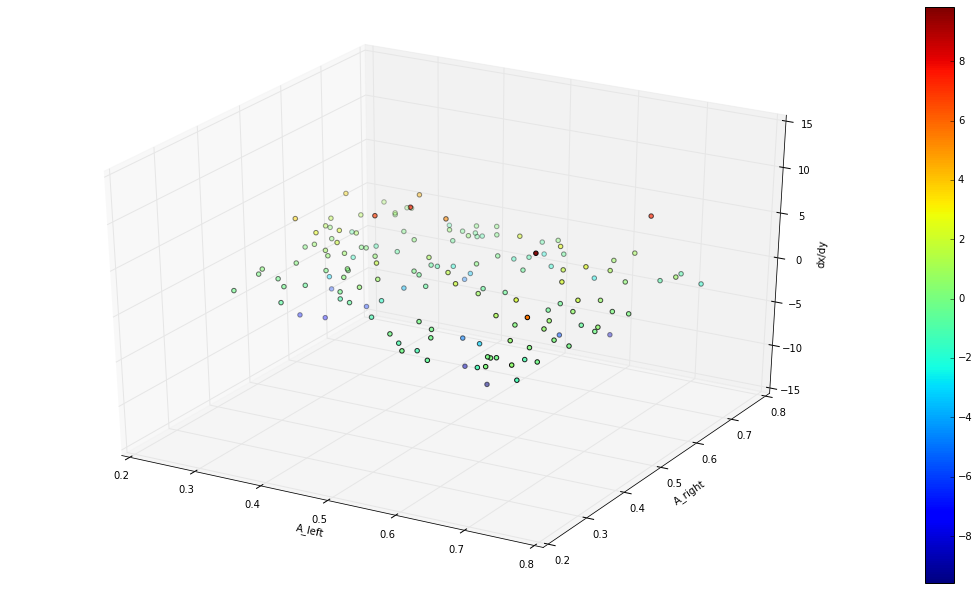

In [323]:
controls_po_25_50 = model.controls[(model.controls[:,0]>=0.25) & (model.controls[:,0]<=0.50)]
print controls_po_25_50.shape
end_states_po_25_50 = model.end_states[(model.controls[:,0]>=0.25) & (model.controls[:,0]<=0.50)]
print end_states_po_25_50.shape
dy_e = end_states_po_25_50[:,0] - end_states_po_25_50[:,26]
dx_e = end_states_po_25_50[:,1] - end_states_po_25_50[:,27]
slope = dx_e/dy_e
print slope.shape

# cm = plt.get_cmap("RdYlGn")
# fig = plt.figure()
# ax = plt.subplot(111, projection='3d')
# # c = plt.scatter(model.controls[:,2],slope, c='r')
# # plt.ylim([-15,15])
# ax.plot(controls_po_25_50[:,2],controls_po_25_50[:,3],slope, 
#         ms=2, marker='o', c=[cm(i) for i in slope/np.max(slope)] )
# ax.set_xlabel("A_left")
# ax.set_ylabel("A_right")
# # plt.zlabel("dx/dy")
# ax.set_zlabel("dx/dy")
# ax.set_zlim([-5,5])
# plt.show()

scatter3d(controls_po_25_50[:,2][(slope<10) & (slope>-10)],controls_po_25_50[:,3][(slope<10) & (slope>-10)],slope[(slope<10) & (slope>-10)], slope[(slope<10) & (slope>-10)])

Size:  (1774, 91)


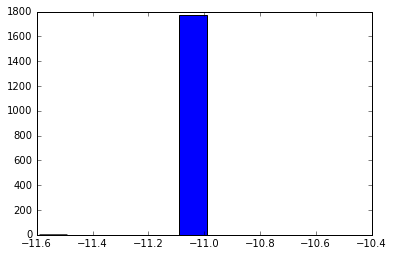

Size:  (1774, 91)


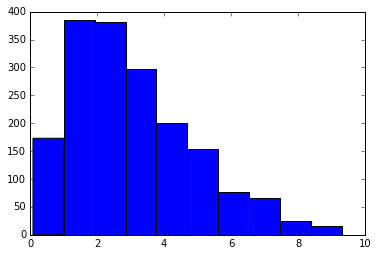

In [26]:
idx = 39

print "Size: ", model.start_states.shape
plt.figure(1)
plt.hist(model.start_states[:,idx])
plt.show()

print "Size: ", model.end_states.shape
plt.figure(2)
plt.hist(np.sqrt(np.square(model.end_states[:,idx] - model.start_states[:,idx]) + 
         np.square(model.end_states[:,idx+1] - model.start_states[:,idx+1])))
plt.show()


In [6]:
dx_e = model.end_states[:,0] - model.end_states[:,26]
dy_e = model.end_states[:,1] - model.end_states[:,27]
slope = dx_e/dy_e
print slope
plt.figure(3)
# plt.hist(slope)
bins = np.linspace(-25,25,40)
n, bins_out, plot = plt.hist(slope, 
                         bins, alpha=0.5, label="pred")
plt.show()

[ -1.39484262e+00  -8.96256685e-01  -5.18211842e-01  -5.26330233e-01
   8.17207432e+00   5.02377868e-01   4.43460315e-01  -4.99783516e-01
  -1.46111178e+00  -9.46809590e-01   8.20417166e-01   9.05434012e-01
  -1.66886353e+00   2.71270961e-01   1.77884400e-01  -5.49472094e-01
  -1.76236403e+00  -1.18169546e+00   6.87397182e-01   2.82314968e+00
  -6.11861169e-01  -3.51144820e-01   1.60206831e+00  -6.99936724e+00
  -1.00346327e+00   1.42682004e+00  -6.82294428e-01   1.10877144e+00
   2.33881998e+00   8.16292614e-02  -9.65542078e-01  -1.04503475e-01
   5.82238817e+00   1.35525549e-02  -2.57317719e+02  -4.05156434e-01
  -6.26314998e-01  -3.01153469e+00   1.07591665e+00  -9.94477940e+00
  -1.15931354e-01   4.48381233e+00  -1.72490239e+00  -2.02648711e+00
   7.38834143e-01  -1.62317634e-01  -1.67696369e+00   4.52492177e-01
  -1.40631235e+00  -3.08823490e+01   4.03257320e-03   3.93429446e+00
  -3.54464889e-01  -1.23309232e-01  -4.09583747e-01  -8.83768141e-01
   1.63140178e+00  -2.69220662e+00